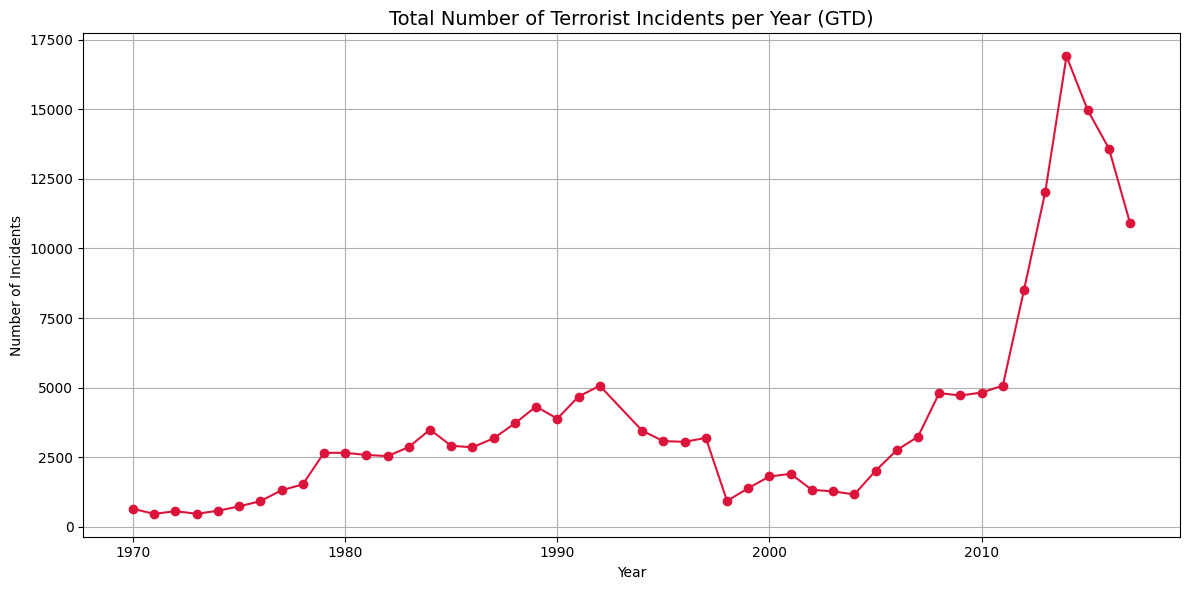

In [1]:
#1. Annual Trend of Terrorist Incidents (GTD Only)
import pandas as pd
import matplotlib.pyplot as plt
gtd = pd.read_csv("gtd.csv", encoding='latin1', low_memory=False)
gtd = gtd[gtd['iyear'].notnull()]
incident_trend = gtd.groupby('iyear').size().reset_index(name='num_incidents')
plt.figure(figsize=(12, 6))
plt.plot(incident_trend['iyear'], incident_trend['num_incidents'], marker='o', color='crimson')
plt.title('Total Number of Terrorist Incidents per Year (GTD)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.tight_layout()
plt.show()

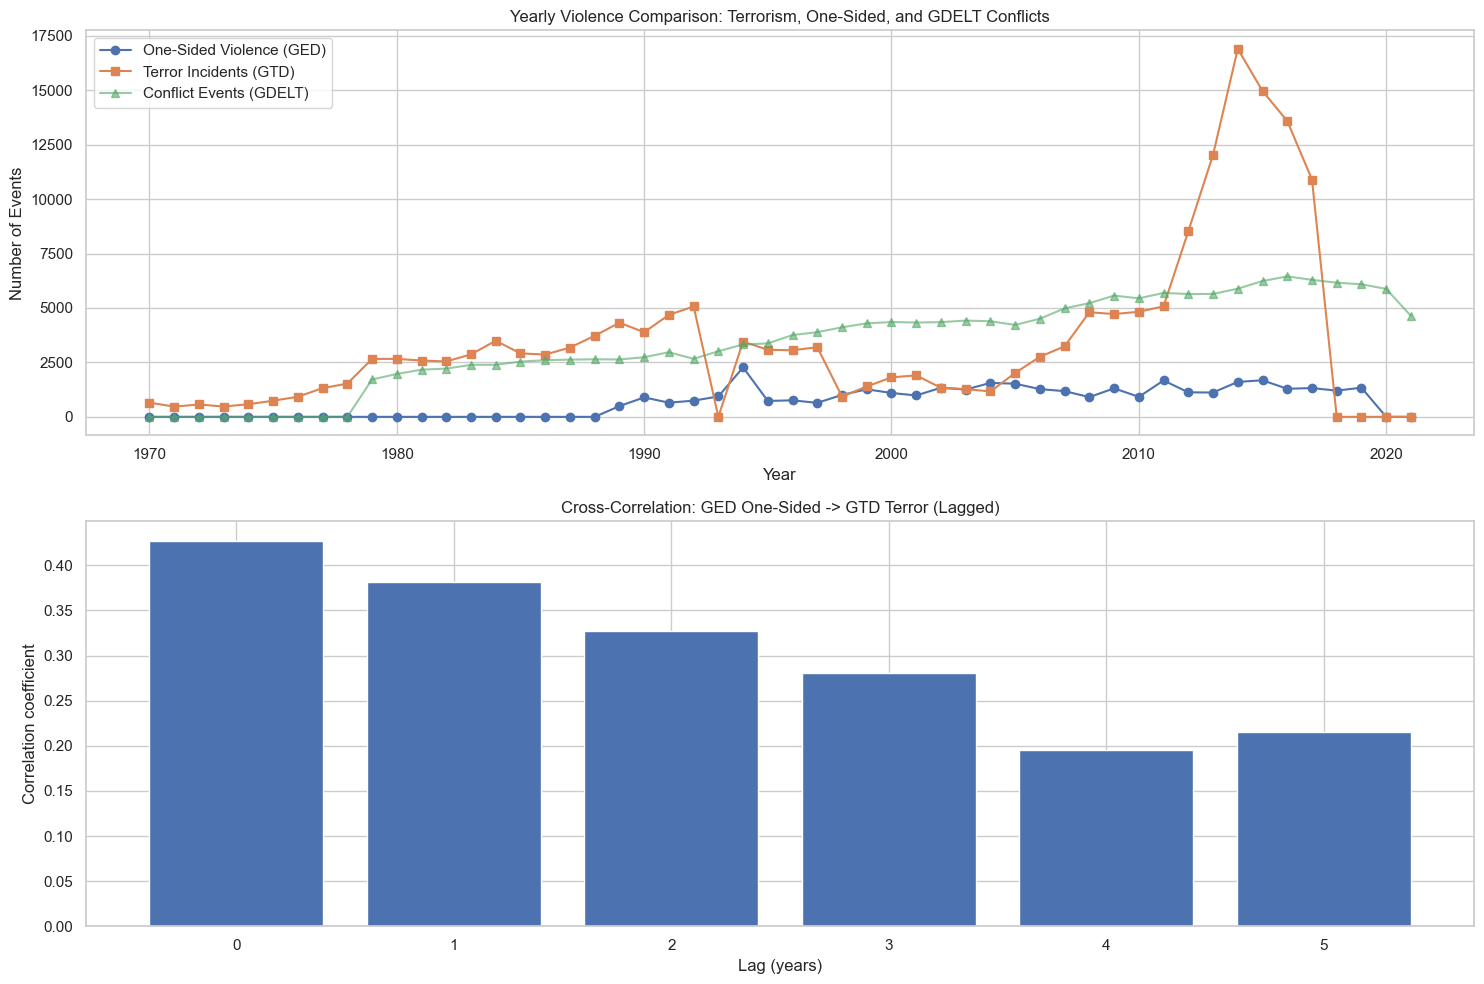

Highest correlation (r = 0.43) occurs at a lag of 0 year(s).


In [1]:
#2 Cross-Correlation of Terrorism (GTD), One-Sided Violence (GED), and Conflict Events (GDELT)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

mpl.rcParams['font.family'] = 'DejaVu Sans'
sns.set(style="whitegrid")

gtd = pd.read_csv("gtd.csv", encoding="latin1", low_memory=False)
ged = pd.read_csv("ged.csv", low_memory=False)
gdelt = pd.read_csv("gdelt_conflict.csv", low_memory=False)

gtd = gtd[gtd['iyear'].notnull()]
terror = (
    gtd.groupby('iyear')
       .size()
       .reset_index(name='terror_incidents')
       .rename(columns={'iyear': 'year'})
)

ged = ged[ged['year'].notnull()]
one_sided = (
    ged[ged['type_of_violence'] == 3]
       .groupby('year')
       .size()
       .reset_index(name='one_sided_incidents')
)

gdelt = gdelt[gdelt['Year'].notnull()]
gdelt_events = (
    gdelt.groupby('Year')
         .size()
         .reset_index(name='gdelt_events')
         .rename(columns={'Year': 'year'})
)

df = pd.merge(terror, one_sided, on='year', how='outer')
df = pd.merge(df, gdelt_events, on='year', how='outer')
df = df.fillna(0).sort_values('year')

max_lag = 5
lags = list(range(max_lag + 1))
cors = [df['terror_incidents'].corr(df['one_sided_incidents'].shift(l)) for l in lags]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

ax1.plot(df['year'], df['one_sided_incidents'], marker='o', label='One-Sided Violence (GED)')
ax1.plot(df['year'], df['terror_incidents'], marker='s', label='Terror Incidents (GTD)')
ax1.plot(df['year'], df['gdelt_events'], marker='^', label='Conflict Events (GDELT)', alpha=0.6)
ax1.set_title('Yearly Violence Comparison: Terrorism, One-Sided, and GDELT Conflicts')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Events')
ax1.legend()

ax2.bar(lags, cors)
ax2.set_xticks(lags)
ax2.set_xlabel('Lag (years)')
ax2.set_ylabel('Correlation coefficient')
ax2.set_title('Cross-Correlation: GED One-Sided -> GTD Terror (Lagged)')

plt.tight_layout()
plt.show()

best_lag = lags[int(pd.Series(cors).idxmax())]
print(f"Highest correlation (r = {max(cors):.2f}) occurs at a lag of {best_lag} year(s).")


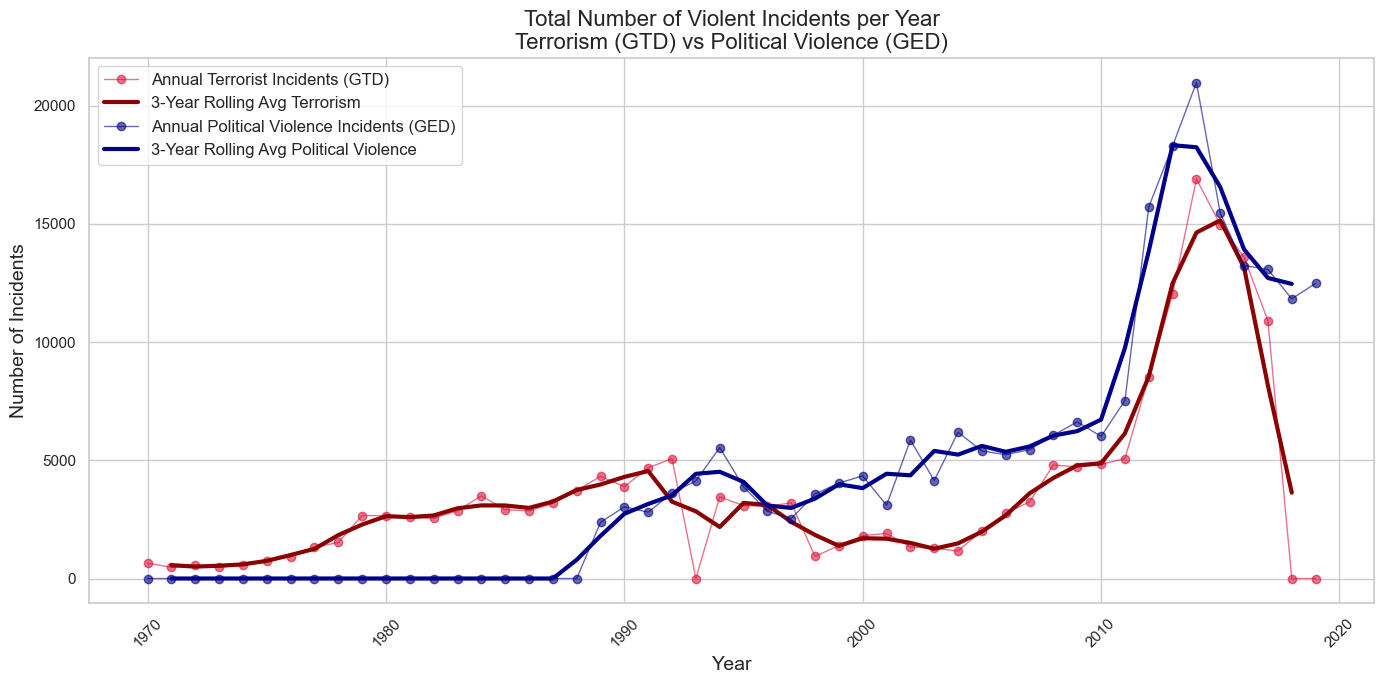

In [2]:
#3. Rolling Averages of Terrorism vs. Political Violence
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

gtd = pd.read_csv("gtd.csv", encoding='latin1', low_memory=False)
gtd = gtd[gtd['iyear'].notnull()]
gtd_incidents = gtd.groupby('iyear').size().reset_index(name='terror_incidents')

ged = pd.read_csv("ged.csv", low_memory=False)
ged = ged[ged['year'].notnull()]
ged_incidents = ged.groupby('year').size().reset_index(name='political_violence_incidents')

merged = pd.merge(gtd_incidents, ged_incidents, left_on='iyear', right_on='year', how='outer')

merged['terror_incidents'] = merged['terror_incidents'].fillna(0)
merged['political_violence_incidents'] = merged['political_violence_incidents'].fillna(0)

merged['year'] = merged['iyear'].combine_first(merged['year'])
merged = merged.sort_values('year')

merged['terror_rolling_avg'] = merged['terror_incidents'].rolling(window=3, center=True).mean()
merged['political_rolling_avg'] = merged['political_violence_incidents'].rolling(window=3, center=True).mean()

plt.figure(figsize=(14, 7))

plt.plot(merged['year'], merged['terror_incidents'], 
         label='Annual Terrorist Incidents (GTD)', color='crimson', alpha=0.6, marker='o', linewidth=1)
plt.plot(merged['year'], merged['terror_rolling_avg'], 
         label='3-Year Rolling Avg Terrorism', color='darkred', linewidth=3)

plt.plot(merged['year'], merged['political_violence_incidents'], 
         label='Annual Political Violence Incidents (GED)', color='navy', alpha=0.6, marker='o', linewidth=1)
plt.plot(merged['year'], merged['political_rolling_avg'], 
         label='3-Year Rolling Avg Political Violence', color='darkblue', linewidth=3)

plt.title('Total Number of Violent Incidents per Year\nTerrorism (GTD) vs Political Violence (GED)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Incidents', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


GTD decades: [1970, 1980, 1990, 2000, 2010]
GED decades: [1980, 1990, 2000, 2010]
Plotting decades (excluding 1980): [1990, 2000, 2010]


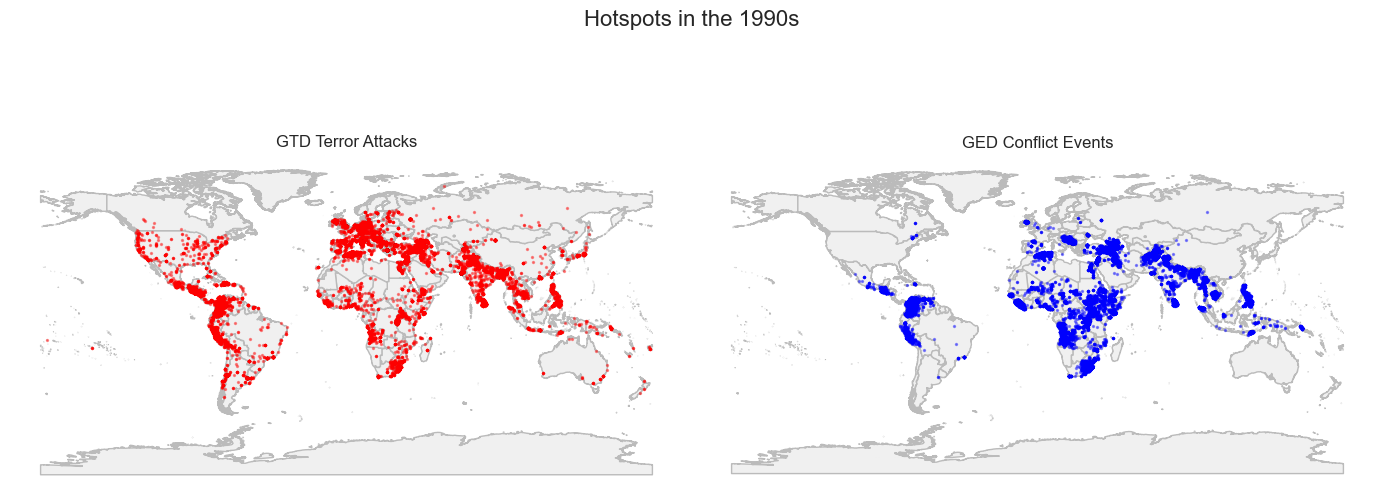

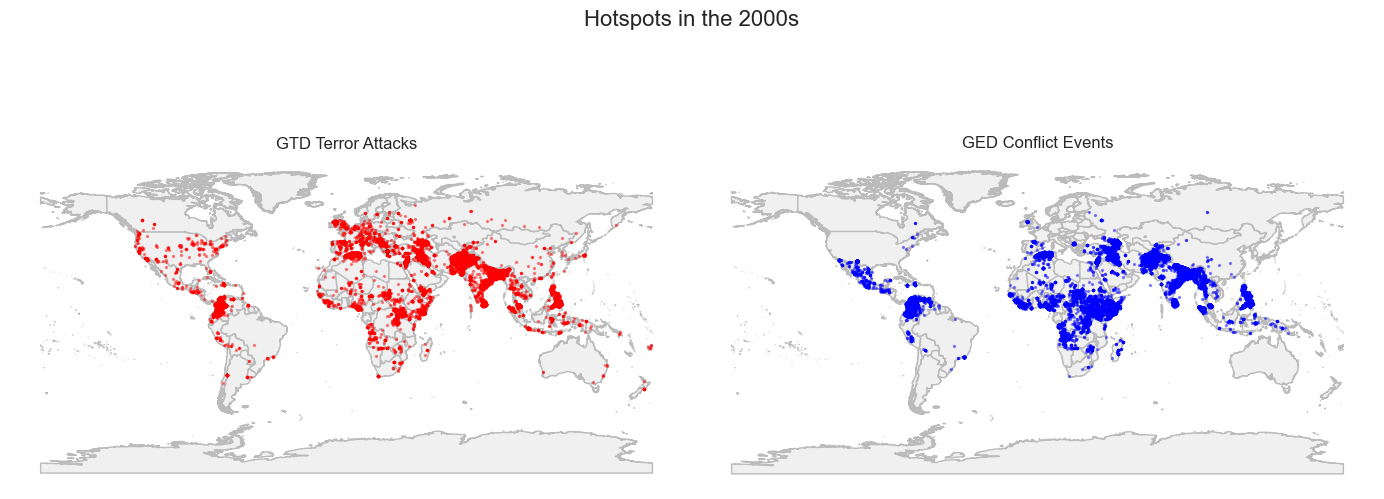

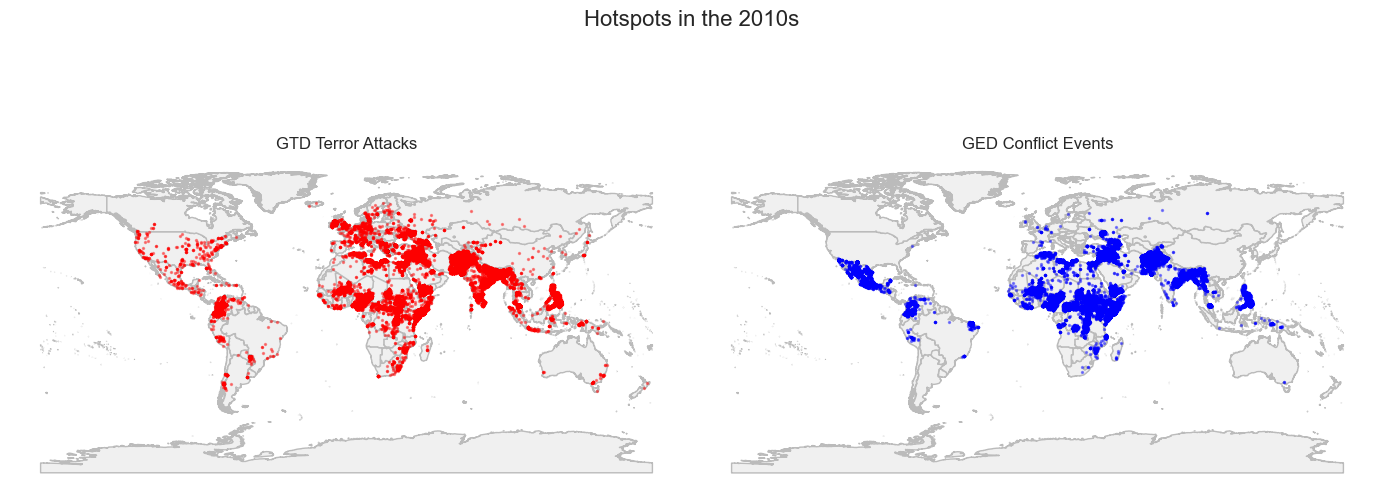

In [4]:
# 4. Geographic Hotspot Maps by Decade (1980s-2010s)
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
world = gpd.read_file(
    "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
)

gtd = pd.read_csv("gtd.csv", usecols=["iyear", "longitude", "latitude"],
                  encoding="latin1", low_memory=False)
gtd.dropna(subset=["longitude", "latitude"], inplace=True)
gtd['decade'] = (gtd['iyear'] // 10 * 10).astype(int)
gtd_gdf = gpd.GeoDataFrame(
    gtd, geometry=[Point(xy) for xy in zip(gtd.longitude, gtd.latitude)],
    crs="EPSG:4326"
)
ged = pd.read_csv("ged.csv", usecols=["year", "longitude", "latitude"], low_memory=False)
ged.dropna(subset=["longitude", "latitude"], inplace=True)
ged['decade'] = (ged['year'] // 10 * 10).astype(int)
ged_gdf = gpd.GeoDataFrame(
    ged, geometry=[Point(xy) for xy in zip(ged.longitude, ged.latitude)],
    crs="EPSG:4326"
)
print("GTD decades:", sorted(gtd_gdf['decade'].unique()))
print("GED decades:", sorted(ged_gdf['decade'].unique()))

common_decades = sorted(set(gtd_gdf['decade']).intersection(ged_gdf['decade']))
decades_to_plot = [dec for dec in common_decades if dec != 1980][:4]
print("Plotting decades (excluding 1980):", decades_to_plot)

for dec in decades_to_plot:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
    plt.suptitle(f"Hotspots in the {dec}s", fontsize=16)

    world.plot(ax=ax1, color="#f0f0f0", edgecolor="#bbbbbb")
    subset = gtd_gdf[gtd_gdf['decade'] == dec]
    subset.plot(ax=ax1, markersize=2, alpha=0.4, color="red")
    ax1.set_title("GTD Terror Attacks")
    ax1.set_axis_off()
    
    world.plot(ax=ax2, color="#f0f0f0", edgecolor="#bbbbbb")
    subset2 = ged_gdf[ged_gdf['decade'] == dec]
    subset2.plot(ax=ax2, markersize=2, alpha=0.4, color="blue")
    ax2.set_title("GED Conflict Events")
    ax2.set_axis_off()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


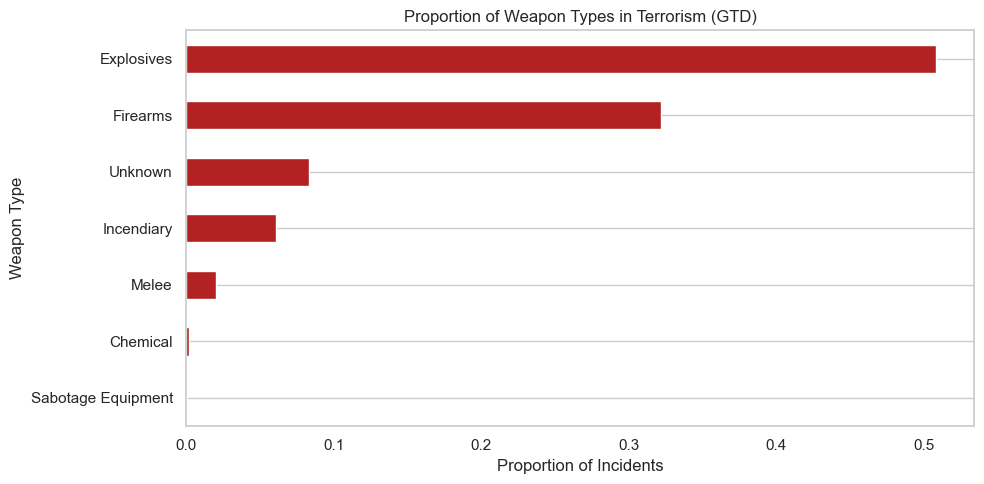

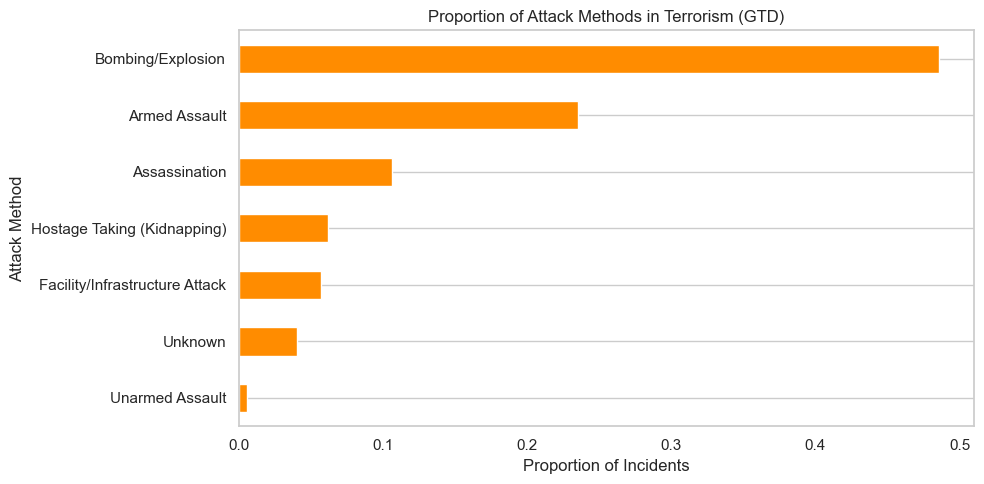

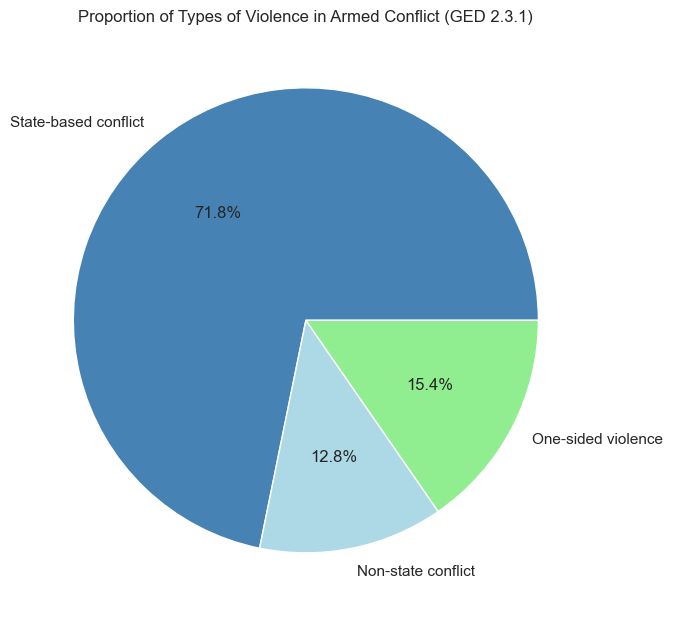

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

gtd = pd.read_csv("gtd.csv", encoding='latin1', low_memory=False,
                  usecols=['weaptype1_txt', 'attacktype1_txt'])
gtd = gtd.dropna(subset=['weaptype1_txt', 'attacktype1_txt'])

weapon_counts = gtd['weaptype1_txt'].value_counts(normalize=True).head(7)
attack_counts = gtd['attacktype1_txt'].value_counts(normalize=True).head(7)

ged231 = pd.read_csv("ged_231.csv", low_memory=False) 

if 'type_of_violence' in ged231.columns:
    ged_violence_counts = ged231['type_of_violence'].value_counts(normalize=True).sort_index()
    violence_map = {
        1: 'State-based conflict',
        2: 'Non-state conflict',
        3: 'One-sided violence'
    }
    ged_violence_counts.index = ged_violence_counts.index.map(violence_map)
else:
    ged_violence_counts = pd.Series()

plt.figure(figsize=(10,5))
weapon_counts.sort_values().plot(kind='barh', color='firebrick')
plt.title("Proportion of Weapon Types in Terrorism (GTD)")
plt.xlabel("Proportion of Incidents")
plt.ylabel("Weapon Type")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
attack_counts.sort_values().plot(kind='barh', color='darkorange')
plt.title("Proportion of Attack Methods in Terrorism (GTD)")
plt.xlabel("Proportion of Incidents")
plt.ylabel("Attack Method")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

if not ged_violence_counts.empty:
    plt.figure(figsize=(7,7))
    ged_violence_counts.plot(kind='pie', autopct='%1.1f%%', colors=['steelblue', 'lightblue', 'lightgreen'])
    plt.title("Proportion of Types of Violence in Armed Conflict (GED 2.3.1)")
    plt.ylabel('')
    plt.tight_layout()
    plt.show()
else:
    print("No 'type_of_violence' data found in GED 2.3.1 dataset.")
